In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
sns.set()
import sys

sys.path.insert(0, "../")

In [4]:
from RGES.DiffEx import DiffEx
from RGES.L1KGCT import MultiL1KGCT
from RGES.Score import score

# Comparing Python RGES To LINCS L1000 Concordance Scores

## Introduction

Our goal is to identify drugs that produce signatures *reverse* to the differential expression signatures seen in platinum-based drug resistance. To do this, we calculate a Reverse Gene Expression Score using a similar method to [Chen et al](https://www.nature.com/articles/ncomms16022#supplementary-information). This notebook tests the implementation of RGES by checking for correlation with the [iLINCS](http://www.ilincs.org/ilincs/signaturesL1000/LDG-1188/search/) portal concordance score for Carboplatin resistance. The steps to acquire the iLINCS concordance score are described below.

## Loading Concordance Scores

Concordance scores are stored at ```/mnt/oncogxA/Alex/l1k/CTPRES_ilincs_concordance.tsv```

This code loads the concordance data and then creates a dictionary of ```{signature_name: concordance_score}```

In [5]:
#concord_path = "/home/jovyan/oncogxA/Alex/l1k/CTPRES_ilincs_concordance.tsv"
#concord_path = "/home/jovyan/oncogxA/Alex/l1k/ilincs_ctprs_100top_100bottom_concord.xls"
#concord_path = "/home/jovyan/oncogxA/Alex/l1k/ilincs_ctprs_skip5.xls"
concord_path = "/home/jovyan/oncogxA/Alex/l1k/10x_ilincs_concordance.xls"
concord_df = pd.read_csv(concord_path, sep='\t')

conc_d = {r['SignatureId']: r['Concordance'] for _, r in concord_df.iterrows()}

## Loading Carboplatin Signature and LINCS Signatures Data

This code loads the CTPRES file and the LINCS Signatures file, which are at

```/mnt/oncogxA/Alex/l1k/res.df.entrez.txt```

/mnt/oncogxA/Alex/l1k/CTPRES_100_concordant_sigs.gct

In [29]:
#de = DiffEx("/home/jovyan/oncogxA/Alex/l1k/res.df.entrez.txt")
de = DiffEx("/home/jovyan/oncogxA/Alex/l1k/DEG_SC_5um_entrezgene.txt")

#lincs_sigs = MultiL1KGCT("/home/jovyan/oncogxA/Alex/l1k/CTPRES_100_concordant_sigs.gct", normalized=True)
#lincs_sigs = MultiL1KGCT("/home/jovyan/oncogxA/Alex/l1k/ilincs_ctprs_100top_100bottom.gct", normalized=True)
#lincs_sigs = MultiL1KGCT("/home/jovyan/oncogxA/Alex/l1k/ilincs_ctprs_skip5.gct", normalized=True)
lincs_sigs = MultiL1KGCT("/home/jovyan/oncogxA/Alex/l1k/10x_ilincs_sigs_top500.gct", normalized=True)

In [30]:
## Run this cell if there are log2fc.x and log2fc.y columns

merge_l2fc = lambda x: -1.0*x['log2fc.y'] if not np.isnan(x['log2fc.y']) else x['log2FoldChange']

de.data['log2FoldChange'] = de.data.apply(merge_l2fc, axis=1)

## Calculate Scores For Each Signature

In [33]:
points = []  #[(concordance, RGES)]

for signame in lincs_sigs.metadata.keys():
    concordance = conc_d[signame]
    rges = score(de, lincs_sigs, signame)
    points.append((concordance, rges))

(-0.75967567292275295, 4.0105677371667816e-95)

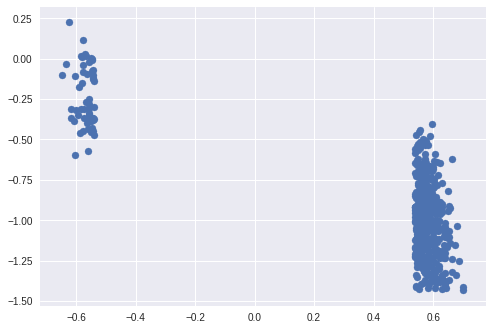

In [34]:
x = [p[0] for p in points]
y = [p[1] for p in points]
plt.scatter(x, y)
pearsonr(x, y)

## Querying the iLINCS Concordance For CTPRES

**TODO**: Write up a description of how to get concordance for a phenotype signature. Its in my notes for 2018-03-27